# Taxi Trip Duration


- [www.nyc.gov](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)


Run the Mlflow UI:

```sh
uv run --with mlflow==3.7.0 mlflow ui --backend-store-uri sqlite:///mlflow.db
```


Install packages


In [75]:
!uv pip install -q \
    mlflow==3.7.0 \
    python-dotenv==1.2.1 \
    pandas==2.3.2 \
    pandas-stubs==2.3.2.250827 \
    numpy==2.3.2 \
    matplotlib==3.10.6 \
    seaborn==0.13.2 \
    scikit-learn==1.7.1 \
    tqdm==4.67.1 \
    xgboost==3.1.2 \
    pyarrow==22.0.0 \
    hyperopt==0.2.7 \
    setuptools==80.9.0

Append notebooks directory to sys.path


In [ ]:
import sys

sys.path.append("../../..")

Import packages


In [76]:
import os
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import pickle
import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

pd.set_option("display.max_columns", None)

sns.set_style("darkgrid")
sns.set_theme(style="darkgrid")

%matplotlib inline

/home/gabrieldmenezes/.cache/uv/builds-v0/.tmpEelOuC/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Set tracking uri


In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

Set experiment


In [ ]:
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1768329930640, experiment_id='1', last_update_time=1768329930640, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

Create data directory


In [ ]:
BASE_PATH = pathlib.Path("../../machine-learning")
DATA_DIR = BASE_PATH / "data/taxi-trip-duration"
OUTPUT_DIR = BASE_PATH / "artifacts/taxi-trip-duration"

DATA_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

Download dataset


In [ ]:
train_file_path = DATA_DIR / "green_tripdata_2021-01.parquet"
train_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
validation_file_path = DATA_DIR / "green_tripdata_2021-02.parquet"
validation_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"


def load_preprocess_data(url, file_path):
    if not file_path.exists():
        df = pd.read_parquet(url, engine="pyarrow")
        df.to_parquet(file_path, engine="pyarrow")
    else:
        df = pd.read_parquet(file_path, engine="pyarrow")

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

    # In minutes
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]

    df[categorical] = df[categorical].astype(str)

    return df


df_train = load_preprocess_data(train_url, train_file_path)
df_validation = load_preprocess_data(validation_url, validation_file_path)

df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,0.5,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [ ]:
len(df_train), len(df_validation)

(73908, 61921)

Duration distribution


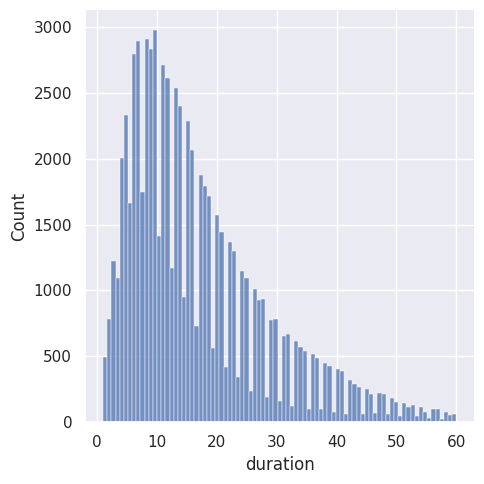

In [ ]:
sns.displot(df_train.duration)
plt.show()

Check statistics measures, due to long tail is difficult to use the distribution chart


In [ ]:
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

One hot encoding


In [ ]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

dict_vectorizer = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dict_vectorizer.fit_transform(train_dicts)

validation_dicts = df_validation[categorical + numerical].to_dict(
    orient="records"
)
X_validation = dict_vectorizer.transform(validation_dicts)

Target


In [ ]:
target = "duration"
y_train = df_train[target].values
y_validation = df_validation[target].values

Train Model


In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
print(linear_regression)

LinearRegression()


Make predictions


In [ ]:
y_validation_pred = linear_regression.predict(X_validation)

Compare predictions to actual values


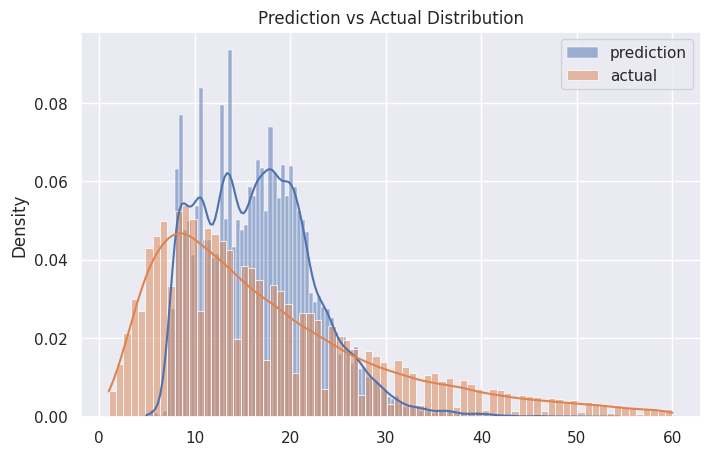

In [ ]:
plt.figure(figsize=(8, 5))

sns.histplot(
    y_validation_pred, label="prediction", kde=True, stat="density", alpha=0.5
)
sns.histplot(y_validation, label="actual", kde=True, stat="density", alpha=0.5)

plt.legend()
plt.title("Prediction vs Actual Distribution")
plt.show()

Calculating RMSE


In [ ]:
root_mean_squared_error(y_validation, y_validation_pred)

10.499110713090017

Lasso model


In [ ]:
with mlflow.start_run():
    mlflow.set_tag("developer", "gabriel")

    alpha = 0.001

    mlflow.log_param("alpha", alpha)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    y_validation_pred = lasso.predict(X_validation)

    rmse = root_mean_squared_error(y_validation, y_validation_pred)

    mlflow.log_metric("rmse", rmse)

🏃 View run flawless-colt-858 at: http://127.0.0.1:5000/#/experiments/1/runs/c2f1d0ba934c49ccbb2c2b561e765283
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Ridge model


In [ ]:
ridge = Ridge(alpha=0.0001)
ridge.fit(X_train, y_train)

y_validation_pred = ridge.predict(X_validation)

root_mean_squared_error(y_validation, y_validation_pred)

10.476414583855084

Define output path


In [ ]:
output_file = OUTPUT_DIR / f"model.bin"
output_file

PosixPath('../../machine-learning/artifacts/taxi-trip-duration/model.bin')

Save the model


In [ ]:
with open(output_file, "wb") as f_out:
    pickle.dump((dict_vectorizer, linear_regression), f_out)

Using xgboost


In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_validation, label=y_validation)

Define objective function


In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_validation, y_pred)
        mlflow.log_metric("rmse", rmse)

        return {"loss": rmse, "status": STATUS_OK}

Hyperparameter optimization


In [ ]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:squarederror",
    "seed": 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials(),
)

[0]	validation-rmse:10.50406                          
[1]	validation-rmse:9.25843                           
[2]	validation-rmse:8.36503                           
[3]	validation-rmse:7.73652                           
[4]	validation-rmse:7.29620                           
[5]	validation-rmse:6.99338                           
[6]	validation-rmse:6.78647                           
[7]	validation-rmse:6.64093                           
[8]	validation-rmse:6.54016                           
[9]	validation-rmse:6.47001                           
[10]	validation-rmse:6.41543                          
[11]	validation-rmse:6.37604                          
[12]	validation-rmse:6.34569                          
[13]	validation-rmse:6.32333                          
[14]	validation-rmse:6.30908                          
[15]	validation-rmse:6.29706                          
[16]	validation-rmse:6.28672                          
[17]	validation-rmse:6.27934                          
[18]	valid

KeyboardInterrupt: 

Train model with autolog


In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_validation, label=y_validation)

    best_params = {
        "learning_rate": 0.09585355369315604,
        "max_depth": 30,
        "min_child_weight": 1.060597050922164,
        "objective": "reg:squarederror",
        "reg_alpha": 0.018060244040060163,
        "reg_lambda": 0.011658731377413597,
        "seed": 42,
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, "validation")],
        early_stopping_rounds=50,
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_validation, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:11.42590
[1]	validation-rmse:10.73579
[2]	validation-rmse:10.13221
[3]	validation-rmse:9.60467
[4]	validation-rmse:9.14350
[5]	validation-rmse:8.74783
[6]	validation-rmse:8.40625
[7]	validation-rmse:8.10997
[8]	validation-rmse:7.85840
[9]	validation-rmse:7.64037
[10]	validation-rmse:7.45297
[11]	validation-rmse:7.29362
[12]	validation-rmse:7.15680
[13]	validation-rmse:7.04125
[14]	validation-rmse:6.94028
[15]	validation-rmse:6.85573
[16]	validation-rmse:6.78299
[17]	validation-rmse:6.71884
[18]	validation-rmse:6.66419
[19]	validation-rmse:6.61703
[20]	validation-rmse:6.57526
[21]	validation-rmse:6.53977
[22]	validation-rmse:6.50992
[23]	validation-rmse:6.48222
[24]	validation-rmse:6.45739
[25]	validation-rmse:6.43638
[26]	validation-rmse:6.41823
[27]	validation-rmse:6.40113
[28]	validation-rmse:6.38730
[29]	validation-rmse:6.37475
[30]	validation-rmse:6.36221
[31]	validation-rmse:6.35130
[32]	validation-rmse:6.34307
[33]	validation-rmse:6.33527
[34]	validation-rmse:

2026/01/13 18:01:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/13 18:01:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run bemused-roo-245 at: http://127.0.0.1:5000/#/experiments/1/runs/5a5c2bfddea1471d8cd5df63743aa9f8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## Pipeline

Converting to a pipeline


```py title='taxi-trip-duration-pipeline.py'
--8<-- "docs/notebooks/python/mlops/mlfow/taxi-trip-duration-pipeline.py"
```
